In [1]:
import openmc
import numpy as np
import time
import csv

In [2]:
#need to pull the csv file that contains the isotopic composition, dashes have been omitted!!!!
comps = []
with open("decay_isotopes.csv") as csvfile:
    reader = csv.reader(csvfile)#, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        comps.append(row)
converted_data = [[item[0], float(item[1])] for item in comps]

#need to develop the fuel composition now
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 0.015315)

for nuclide, ao in converted_data:
    fuel.add_nuclide(nuclide, ao)

#fuel

In [3]:
#need to develop the TRISO particle now!!!!
#need to add buffer layer:
Buffer = openmc.Material(name='Buffer')
Buffer.set_density('g/cm3', 1.02)
Buffer.add_element('C', 1.0)
#need to develop the fuel com
Buffer.add_s_alpha_beta('c_Graphite')
t_Buffer = 0.01 #thickeness of buffer layer

#adding the PyC layer
PyC = openmc.Material(name='PyC1')
PyC.set_density('g/cm3', 1.92)
PyC.add_element('C', 1.0)
PyC.add_s_alpha_beta('c_Graphite')
tiPyC = 0.0039 #thickness of inner PyC
toPyC = tiPyC

#adding the SiC layer
SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)
tSic = 0.0035 #thickness of SiC

#outer pebble material
graphite = openmc.Material()
graphite.set_density('g/cm3', 1.7) #A3-3 Graphite
graphite.add_element('C', 1.0) 
#graphite.add_s_alpha_beta('c_Graphite')


#cask fill insert, may also be helium
air = openmc.Material(name='air')
air.set_density('atom/b-cm', 0.0006) #'atom/b-cm', 0.0006
air.add_element('N',0.78)
air.add_element('O',0.21)
air.add_element('Ar',0.01)


#cask materials 

#inner cask
SS304 = openmc.Material(name = 'SS304')
SS304.set_density('g/cm3',7.93)
SS304.add_element('C',0.08/100,'wo')
SS304.add_element('P',0.045/100,'wo')
SS304.add_element('Si',0.75/100, 'wo')
SS304.add_element('Ni',13.5/100, 'wo')
SS304.add_element('N',0.1/100,'wo')
SS304.add_element('Mn',2/100, 'wo')
SS304.add_element('S',0.03/100,'wo')
SS304.add_element('Cr',19/100,'wo')
SS304.add_element('B',2.250/100,'wo')
SS304.add_element('Fe',62.245/100,'wo')
t_ss = 2 #cm

#concrete
conc = openmc.Material(name = 'conc')
conc.set_density('g/cm3',5.43)

#duagg
duagg = openmc.Material(name = 'duagg')
duagg.add_element('Al',0.61/100,'wo')
duagg.add_element('Cu',0.04/100,'wo')
duagg.add_element('Fe',0.42/100,'wo')
duagg.add_element('K',0.14/100,'wo')
duagg.add_element('Mg',0.15/100,'wo')
duagg.add_element('Si',2.16/100,'wo')
duagg.add_element('Sr',0.01/100,'wo')
duagg.add_element('Ti',1.35/100,'wo')
duagg.add_element('Zr',0.85/100,'wo')

#du 
du = openmc.Material(name = 'du')
du.add_nuclide('U238',0.998,'wo')
du.add_nuclide('U235',0.002,'wo')

agg = openmc.Material.mix_materials([duagg, du], [0.0629, .9371], 'wo')

#portland concrete
conc_mix = openmc.Material(name = 'conc_mix')
conc_mix.add_element('He',0.01, 'wo')
conc_mix.add_element('C',0.001, 'wo')
conc_mix.add_element('O',0.529107, 'wo')
conc_mix.add_element('Na',0.016, 'wo')
conc_mix.add_element('Mg',0.002, 'wo')
conc_mix.add_element('Al',0.033872, 'wo')
conc_mix.add_element('Si',0.337021, 'wo')
conc_mix.add_element('K',0.013, 'wo')
conc_mix.add_element('Ca',0.044, 'wo')
conc_mix.add_element('Fe',0.014, 'wo')


#water 
water = openmc.Material(name = 'water')
water.add_element('H', 2)
water.add_element('O', 1)
#water.add_s_alpha_beta('c_H_in_H2O')

conc = openmc.Material.mix_materials([agg, conc_mix, water], [0.86378, .105597,0.030623], 'wo')
t_conc = 20 #cm

#XM-19
xm19 = openmc.Material(name = 'xm19')
xm19.set_density('g/cm3',7.88)
xm19.add_element('Cr',22/100,'wo')
xm19.add_element('Ni',12.5/100,'wo')
xm19.add_element('Mn',5/100,'wo')
xm19.add_element('Mo',2.25/100,'wo')
xm19.add_element('Si',1/100,'wo')
xm19.add_element('N',0.3/100,'wo')
xm19.add_element('Nb',0.2/100,'wo')
xm19.add_element('P',0.2/100,'wo')
xm19.add_element('C',0.06/100,'wo')
xm19.add_element('S',0.01/100,'wo')
xm19.add_element('Fe',56.48/100,'wo')
t_xm19 = 10 #cm

#fuel-carbon mix
fuel_mix = openmc.Material.mix_materials([fuel, graphite], [0.0612638171436, 0.938736182862], 'wo')



#in centimeters (assuming it to be, looking at above units), need to check this with ZOE
#fuel pebble dimensions
peb_or = 3 #non-fuel portion
peb_ir = 2.5 #fuel portion

#TRISO particle dimensions
kernel_or = 0.02545 #radius of fuel kernel
buffer_r = kernel_or + t_Buffer
ipyc_r = buffer_r + tiPyC
sic_r = ipyc_r + tSic
opyc_r = sic_r + tiPyC #should be around 0.0455 cm, it is 0.04675

#water fill
water_fill = openmc.Material(name = 'water')
water_fill.set_density('g/cm3',1)
water_fill.add_element('H', 2)
water_fill.add_element('O', 1)

#helium
he = openmc.Material(name = 'HE')
he.set_density('g/cm3', 0.0491*1000)
he.add_element('He',1,'wo')

#core (cask) dimensions 
core_r = 0.5*100
core_h = 4.16*100

kernelsph = openmc.Sphere(r=kernel_or)
buffsph = openmc.Sphere(r=buffer_r)
IPyCsph = openmc.Sphere(r=ipyc_r)
SiCsph = openmc.Sphere(r=sic_r)
OPyCsph = openmc.Sphere(r=opyc_r)
peb_wfuel = openmc.Sphere(r=peb_ir)
peb_wfuel_outer = -peb_wfuel

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

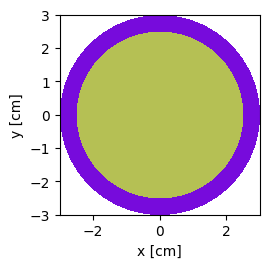

In [4]:
#generating the fuel pebbler
peb_nofuel = openmc.Sphere(r=peb_or) #generates a sphere of this radius
peb_nofuel_zone_outer = -peb_nofuel 
peb_nofuel_zone_inner = +peb_wfuel #creates a non-fuel region for our pebble
peb_fuel_zone = -peb_wfuel

sphere = openmc.Cell(region=peb_wfuel_outer) #only focusing on fuel containing portion of our fuel pebble
sphere.fill = fuel_mix

pebble_element = [sphere,
              openmc.Cell(fill=graphite, region=peb_nofuel_zone_inner & peb_nofuel_zone_outer)]
pebble_univ = openmc.Universe(cells=pebble_element)

active_core_sides = openmc.ZCylinder(r = core_r,boundary_type='vacuum')
active_core_top = openmc.ZPlane(z0=(core_h/2), boundary_type='vacuum')
active_core_bot = openmc.ZPlane(z0=-(core_h/2),boundary_type='vacuum')
active_core_bound = -active_core_sides & -active_core_top & +active_core_bot
pebble_univ.plot()

In [5]:
#code to get the location data for the individual fuel pebbles!!!!!
results = []
new_row = []
with open("position for pebbles/settlephase_final_positions.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        results.append(row)
      
def multiply_list_by_scalar(list_of_lists, scalar):
    output = [[element * scalar for element in sub_list] for sub_list in list_of_lists]
    return output

# Example usage:
my_list = results
scalar_value = 100
multiplied_list = multiply_list_by_scalar(my_list, scalar_value)
multiplied_list[0] 

[-9.26872, -46.08, -205.00500000000002]

In [6]:
print("starting openmc pack")
start_time = time.perf_counter()
peb_centers = multiplied_list
#openmc.model.pack_spheres(peb_or, region=active_core_bound, pf = .40, contraction_rate = 0.0000001)
#need to implement this as an array of a bunch of position arrays, this might be randomly generated
print(time.perf_counter()-start_time)

pebs = [openmc.model.TRISO(peb_or, pebble_univ, peb_center) for peb_center in peb_centers] #display the locations of these pebbles using the ARFC computer
#implement our pebble locations

peb_centertest = np.vstack([peb.center for peb in pebs]) #veritically stacks the above array to easily read the positions of the pebbles
print(peb_centertest.min(axis=0))
print(peb_centertest.max(axis=0))

inner_core = openmc.Cell(region=active_core_bound)
lower_left_core, upper_right_core = inner_core.region.bounding_box
shape_core = (1,1,1)
pitch_core = (upper_right_core - lower_left_core)/shape_core
core_lattice = openmc.model.create_triso_lattice(
    pebs, lower_left_core, pitch_core, shape_core, water)

inner_core.fill=core_lattice

starting openmc pack
5.686399998694469e-05
[ -47.0057  -47.0039 -205.013 ]
[ 47.0076  47.0086 199.709 ]


/home/ceserz2/anaconda3/envs/lammps-openmc/lib/python3.12/site-packages/openmc/model/triso.py:850: UserWarning: TRISO particle is partially or completely outside of the lattice.
  warnings.warn('TRISO particle is partially or completely '


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

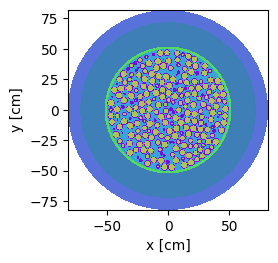

In [7]:
#AGAIN, looking at adding material surrounding the core (or our cask)

#inner cask only
inner_cask_sides = openmc.ZCylinder(r = (core_r+t_ss))
inner_cask_top = openmc.ZPlane(z0=((core_h/2)+t_ss))
inner_cask_bot = openmc.ZPlane(z0=-((core_h/2)+t_ss))
inner_cask_outer = -inner_cask_sides & -inner_cask_top & +inner_cask_bot
inner_cask_bounds = inner_cask_outer | active_core_bound
inner = openmc.Cell(region = inner_cask_bounds, fill = SS304)

#concrete shielding now!!!!
r_conc_in = core_r+t_ss
r_conc_tot = r_conc_in+t_conc
conc_sides = openmc.ZCylinder(r = r_conc_tot, boundary_type='white')
conc_top = openmc.ZPlane(z0=r_conc_tot,boundary_type='white')
conc_bot = openmc.ZPlane(z0=-r_conc_tot,boundary_type='white')
conc_outer = -conc_sides & -conc_top & +conc_bot
conc_cask_bounds = conc_outer | active_core_bound
concrete = openmc.Cell(region = conc_cask_bounds, fill = conc)

#concrete shielding now!!!!
r_xm19_in = r_conc_tot
r_xm19_tot = r_conc_tot+t_xm19
xm19_sides = openmc.ZCylinder(r = r_xm19_tot, boundary_type='vacuum')
xm19_top = openmc.ZPlane(z0=r_xm19_tot,boundary_type='vacuum')
xm19_bot = openmc.ZPlane(z0=-r_xm19_tot,boundary_type='vacuum')
xm19_outer = -xm19_sides & -xm19_top & +xm19_bot
xm19_cask_bounds = xm19_outer | active_core_bound
impact = openmc.Cell(region = xm19_cask_bounds, fill = xm19)
universe = openmc.Universe(cells=[inner_core,inner,concrete,impact])
universe.plot()

In [ ]:
#model has been developed, time to set up the simulation run
geometry = openmc.Geometry(universe)
settings = openmc.Settings()
#settings.temperature = {method': 'interpolation',
#    'range': [293.15, 1200] }
settings.temperature = {'default':294}
settings.particles = 40000
settings.inactive = 5
settings.batches = 50
model = openmc.Model(geometry=geometry, settings=settings)


#developing the tallies
tally = openmc.Tallies()

#need to develop the cell/surface filter in some way???
filter_cell =  openmc.CellFilter(impact)

tally1 = openmc.Tally()

#need to specify between photon 
particle1 = openmc.ParticleFilter('photon')
tally1.scores = ['flux']
energy, dose = openmc.data.dose_coefficients('photon', 'AP')
dose_filter = openmc.EnergyFunctionFilter(energy, dose)
tally1.filters = [filter_cell, particle1, dose_filter]
tally.append(tally1)

model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

[Tally
 	ID             =	10
 	Name           =	
 	Filters        =	CellFilter, ParticleFilter, EnergyFunctionFilter
 	Nuclides       =	
 	Scores         =	['flux']
 	Estimator      =	None
 	Multiply dens. =	True]